# Summary 

* v1 Full Run  - 0.89287
* v2 crossval   - 0.88364
* v3 No Dups - added features - 0.88007 - CV
* v4 No duplicates no features - 0.87485 - CV 
* v5 pseudolables +increases ES and patience reduceonlr
* v6 clusters  - 0.95095 - cv
* v7 selu + adam - 0.98714 - cv 
* v8 additional features q40/q50 + additional cluster
* v9 Add Gaussian Noise 


### To do: 
1. check num folds
1. Add Noise  
1. batch normaliser NB 
1. Additional Feature Selection / Addition 
1. Add cluster features 
1. Pseudolables

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import DBSCAN, KMeans

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import tensorflow
import keras
from keras.layers import Dense, Dropout, GaussianNoise
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers 

from scipy.stats import mode
from collections import Counter
import os 
import tempfile
from math import factorial

from sklearn.preprocessing import StandardScaler

import gc

In [ ]:
# experimental params 
ITERATIONS = 2000
FOLDS = 10

SCALER = StandardScaler()

PSEUDO = True
CLUSTER = True

DROP_DUPS = False

# Import Data

In [ ]:
train = pd.read_csv("../input/tabular-playground-series-feb-2022/train.csv", index_col = 0) 
test = pd.read_csv("../input/tabular-playground-series-feb-2022/test.csv", index_col = 0) 
sub = pd.read_csv("../input/tabular-playground-series-feb-2022/sample_submission.csv", index_col = 0)

In [ ]:
train.head()

In [ ]:
print( "Total segments" , len( train.columns ) -1 ) 

# Feature engineering 
#### From the amazing Ambrosm 
https://www.kaggle.com/ambrosm/tpsfeb22-01-eda-which-makes-sense

In [ ]:
features = train.columns[:-1]

In [ ]:
def bias(w, x, y, z):
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

def bias_of(s):
    w = int(s[1:s.index('T')])
    x = int(s[s.index('T')+1:s.index('G')])
    y = int(s[s.index('G')+1:s.index('C')])
    z = int(s[s.index('C')+1:])
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

train_i = pd.DataFrame({col: ((train[col] + bias_of(col)) * 1000000).round().astype(int) for col in features})
test_i = pd.DataFrame({col: ((test[col] + bias_of(col)) * 1000000).round().astype(int) for col in features})

def gcd_of_all(df_i, elements=features):
    gcd = df_i.index
    for col in elements:
        gcd = np.gcd(gcd, df_i[col])
    return gcd

train['gcd'] = gcd_of_all(train_i)
test['gcd'] = gcd_of_all(test_i)

# del train_i
# del test_i


#### From the master Luca Massaron 
https://www.kaggle.com/lucamassaron/basic-eda-and-model-to-start/notebook#Feature-engineering

In [ ]:
def feature_engineering(df):
    
    df['mean'] = df[features].mean(axis=1)
    df['median'] = df[features].median(axis=1)
    df['q01'] = df[features].quantile(q=0.01, axis=1)
    df['q05'] = df[features].quantile(q=0.05, axis=1)
    df['q10'] = df[features].quantile(q=0.10, axis=1)
    df['q25'] = df[features].quantile(q=0.25, axis=1)
    df['q75'] = df[features].quantile(q=0.75, axis=1)
    df['q90'] = df[features].quantile(q=0.90, axis=1)
    df['q95'] = df[features].quantile(q=0.95, axis=1)
    df['q99'] = df[features].quantile(q=0.99, axis=1)
    df['max'] = df[features].max(axis=1)
    df['min'] = df[features].min(axis=1)
    
    #added
    df['q40'] = df[features].quantile(q=0.40, axis=1)
    df['q50'] = df[features].quantile(q=0.60, axis=1)
    
    df['std'] = df[features].std(axis=1)
    df['range'] = df['max'] - df['min']
    df['iqr'] = df['q75'] - df['q25']
    df['tails'] = df['range'] / df['iqr']
    df['dispersion'] = df['std'] / df['mean']
    df['dispersion_2'] = df['iqr'] / df['median']
    df['skew'] = df[features].skew(axis=1)
    df['kurt'] = df[features].kurt(axis=1)
    
    df['median-max'] = df['median'] - df['max']
    df['median-min'] = df['median'] - df['min']
    df['q99-q95'] = df['q99'] - df['q95']
    df['q99-q90'] = df['q99'] - df['q90']
    df['q01-q05'] = df['q01'] - df['q05']
    df['q01-q10'] =  df['q01'] - df['q10']
    
    return df

feature_engineering(test)
feature_engineering(train)

original_features = features

In [ ]:
features_added= [col for col in train.columns if col not in features]
features_added

# Pseudolabels

In [ ]:
et_1 = pd.read_csv("../input/extra-trees-cv-voting/submission.csv",index_col=0)
et_2 = pd.read_csv("../input/early-ensemble/submission.csv",index_col=0)
et_3 = pd.read_csv("../input/tps-feb-2022/submission.csv",index_col=0)
ensemble = pd.DataFrame({"target": et_2["target"],"target2": et_1["target"],"target3": et_3["target"], })

In [ ]:
if PSEUDO:
    print("Adding Pseudolabels")
    index_e = ensemble[ (ensemble["target"]==ensemble["target2"]) & (ensemble["target2"]==ensemble["target3"])].index
    ensemble =ensemble.loc[index_e].drop(["target2","target3"],axis =1)

    pseudo = pd.concat([test.loc[index_e],ensemble],axis=1 )
    
    train = pd.concat([train,pseudo],axis=0).reset_index(drop=True)

# Duplicates -We have Leakage!! 
From previous Run 

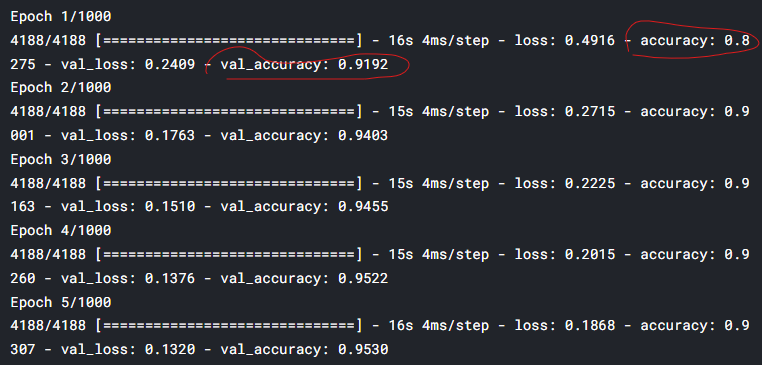

Running our model as is results in a validation loss being lower than training - this is a massive red flag!

either:
1. we are heavily regularizing - dropout , l2,l1 etc 
1. scaling is leaking into validation data   -- its not 
1. Our validation data has attributes of the training 

I spotted duplicates in train - lets remove them and see if it helps 

In [ ]:
if DROP_DUPS: 
    print("Dropping Dups")
    train.drop_duplicates(keep="first", inplace=True,ignore_index=True)
    #train.reset_index(inplace = True)

# Clustering - DBSCAN
The assumption comes from the paper and shows that there is clustering for the classes \
The paper also noted that with the addition of noise, the classes where still distinctive when clustered 

* we will try cluster with multiple distance/min_samples and see if this extra feature assists our final model in distinguishing classes

In [ ]:
if CLUSTER:
    all_df = pd.concat([train.assign(ds="a"),test.assign(ds="b")],axis =0).drop("target",axis=1)
    for idex_e, e in enumerate ([1]): # increase will increase clusters
        for idex_s, min_s in enumerate([6 ,7,8,9, 10]): #increase will decrease clusters 
            print(f"eps: {e} | min_samples: {min_s}")
            clustering = DBSCAN(eps=e, min_samples=min_s).fit(all_df.drop("ds",axis =1))
            labels = clustering.labels_
            print (len(set(labels)) - (1 if -1 in labels else 0))

            col = f"cluster_{idex_e}{idex_s}"

            all_df[col] = labels
            train[col] =  all_df[all_df["ds"]=="a"][col]
            test[col] =  all_df[all_df["ds"]=="b"][col]
            
    for idex_e, e in enumerate ([0.05]): 
        for idex_s, min_s in enumerate([5, 6,7]): 
            print(f"eps: {e} | min_samples: {min_s}")
            clustering = DBSCAN(eps=e, min_samples=min_s).fit(all_df.drop("ds",axis =1))
            labels = clustering.labels_
            print (len(set(labels)) - (1 if -1 in labels else 0))

            col = f"cluster_{idex_e}{idex_s}"

            all_df[col] = labels
            train[col] =  all_df[all_df["ds"]=="a"][col]
            test[col] =  all_df[all_df["ds"]=="b"][col]

# Z-scoring 
### Difference to zscore for each bacteria & for each column  
1. We will look at each column (that is a DNA segment) and calculate the mean and standard deviation for each bacteria
1. We will then take each sample and find the zscore against each bacteria
1. The minimum zscore is identified - and saved in a new column 

In [ ]:
encoder = LabelEncoder()
train["target"] = encoder.fit_transform(train["target"])

In [ ]:
def check_min_zscore(x, bac_mean, bac_std):
    
    z_score = (x-bac_mean)/bac_std
    
    #variance = (x - np.array(bac_mean))**2/ (len(train)-1)
    return np.argmin(z_score)

In [ ]:
segments = [col for col in train.columns if "A" in col]
variance_df = pd.DataFrame(index=train["target"].unique(), columns=[segments])

#for each column 
for col in segments :
    
    #Create arrays to hold mean/std for each bacteria
    bacteria_mean = np.array(train["target"].unique()).astype("float64")
    bacteria_std = np.array(train["target"].unique()).astype("float64")
    
    #for each bacteria type
    for idx, bacteria in enumerate(train["target"].unique()):
        
        #get a slice of train for bacteria and column - then get mean and std dev
        splice = train[train["target"]==bacteria][col]
        
        #create a list of mean values for each bacteria slice 
        bacteria_mean[idx] = np.mean(splice)
        bacteria_std[idx] = np.std(splice)
        
        #std_dev =np.std(splice)
        
    variance_df[col] = bacteria_mean
    print(col)
    #create new column - for each value in column - check if closest to which mean
    train[col+"_"+"z"] = train[col].apply(lambda x: check_min_zscore(x, bacteria_mean,bacteria_std) )
    test[col+"_"+"z"] = test[col].apply(lambda x: check_min_zscore(x, bacteria_mean,bacteria_std) )

# Split and Scale 

In [ ]:
X = train.drop("target",axis =1)
y = train["target"]
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=42)

In [ ]:
scaler = SCALER
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model

In [ ]:
stopping = EarlyStopping(monitor="val_loss",patience = 60)
lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=20)

In [ ]:
def build_model():
    model = Sequential()
    model.add(Dense(300, activation = 'selu', input_shape = (X.shape[1],), 
                   #kernel_regularizer=regularizers.l2(0.001)
                   ))
    model.add(GaussianNoise(0.01))
    model.add(Dense(150, activation = 'selu'
                   #kernel_regularizer=regularizers.l2(0.001)
                   ))  
    #model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'softmax')) # Softmax for multi-class classification
    
    # Compile model 
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])  #try different optimizers 
    return model
model = build_model()

In [ ]:
model.summary()

In [ ]:
# Save weights for later
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
model.fit(X_train,y_train, callbacks= [stopping,lr], validation_data=(X_test, y_test), epochs = ITERATIONS)

#### We still have validation accuracy higher than Training 
However this is more acceptable and the training accuracy improves while the val accuracy stabalises \
This is most likely due to the large amount of training cases vs val cases - i.e. its harder to predict training than validation 

In [ ]:
results = pd.DataFrame(model.history.history )
results

In [ ]:
plt.figure(figsize=(20,10))
results["val_accuracy"].plot()
results["accuracy"].plot()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
results["val_loss"].plot()
results["loss"].plot()
plt.legend()
plt.show()

In [ ]:
val_pred = model.predict(X_test)
val_pred = tensorflow.nn.softmax(val_pred).numpy()
val_pred = np.argmax(val_pred,axis =1)

print(accuracy_score(y_test,val_pred))
print(classification_report(y_test,val_pred ))

### Full Run submission 


In [ ]:
test_pred_full = model.predict(scaler.transform(test)) 

# Covert logits to probabilities 
test_pred_full = tensorflow.nn.softmax(test_pred_full).numpy()
full_preds = encoder.inverse_transform(np.argmax(test_pred_full,axis =1) )
Counter(full_preds)

In [ ]:
sub_full = sub.copy(deep=True)
sub_full["target"] = full_preds
sub_full.to_csv("submission_full.csv")
sub_full.head()

# Cross Validation 

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
scores = []
test_preds = []

#for viz
actuals =[]
preds= []

for idx, (train_idx, val_idx) in enumerate( cv.split(X,y)):
    print (f"\nRunning fold {idx+1}")
    
    X_train , X_test = X.iloc[train_idx] , X.iloc[val_idx]
    y_train, y_test = y[train_idx], y[val_idx]
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    test_s = scaler.transform(test)
    
    model = build_model()
    
    #load weights
    model.load_weights(initial_weights)
    model.fit(X_train,y_train, callbacks= [stopping,lr], validation_data=(X_test, y_test), epochs = ITERATIONS)
      
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, np.argmax(y_pred,axis =1))
    
    scores.append(accuracy)
    print("Accuracy", accuracy) 
    print(classification_report(y_test, np.argmax(y_pred,axis =1)))
    
    #predict TEST 
    test_preds.append(model.predict(test_s)) 
    
    #save actuals and preds for visualisation of missclassified
    actuals.extend( list(y_test))
    preds.extend(y_pred)

    #Save weights
    initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
    model.save_weights(initial_weights)
    
print( "\nFinal Accuracy" , np.mean(accuracy)  )  

# Post Processing and Analysis

In [ ]:
miss_class = pd.DataFrame(data = {"actuals":actuals, "preds":np.argmax(preds,axis =1)})
miss_class["mismatch"] = miss_class["actuals"].astype(str)+"_"+miss_class["preds"].astype(str)

plt.figure(figsize=(25,8))
sns.countplot(miss_class[miss_class["actuals"]!= miss_class["preds"]]["mismatch"], order = miss_class[miss_class["actuals"]!= miss_class["preds"]]["mismatch"].value_counts().index)
plt.title("Miss-Classification: Actual_Predicted ")
plt.show()

# Submission 

In [ ]:
cv_preds = np.argmax(sum(test_preds) / len(test_preds),axis =1)
cv_preds = encoder.inverse_transform(cv_preds)
Counter(cv_preds)

In [ ]:
sub_cv = sub.copy(deep= True)
sub_cv["target"] = cv_preds
sub_cv.to_csv("submission_cv.csv")
sub_cv.head()